In [ ]:
import matplotlib.pylab as plt 
%matplotlib inline

import tifffile as tiff

REBIN IDL

In [1]:
import numpy as np
import scipy.interpolate
import scipy.ndimage

def congrid(a, newdims, method='linear', centre=False, minusone=False):
    '''Arbitrary resampling of source array to new dimension sizes.
    Currently only supports maintaining the same number of dimensions.
    To use 1-D arrays, first promote them to shape (x,1).
    
    Uses the same parameters and creates the same co-ordinate lookup points
    as IDL''s congrid routine, which apparently originally came from a VAX/VMS
    routine of the same name.

    method:
    neighbour - closest value from original data
    nearest and linear - uses n x 1-D interpolations using
                         scipy.interpolate.interp1d
    (see Numerical Recipes for validity of use of n 1-D interpolations)
    spline - uses ndimage.map_coordinates

    centre:
    True - interpolation points are at the centres of the bins
    False - points are at the front edge of the bin

    minusone:
    For example- inarray.shape = (i,j) & new dimensions = (x,y)
    False - inarray is resampled by factors of (i/x) * (j/y)
    True - inarray is resampled by(i-1)/(x-1) * (j-1)/(y-1)
    This prevents extrapolation one element beyond bounds of input array.
    '''
    if not a.dtype in [np.float64, np.float32]:
        a = np.cast[float](a)
    
    m1 = np.cast[int](minusone)
    ofs = np.cast[int](centre) * 0.5
    old = np.array( a.shape )
    ndims = len( a.shape )
    if len( newdims ) != ndims:
        print("[congrid] dimensions error. " \
              "This routine currently only support " \
              "rebinning to the same number of dimensions.")
        return None
    newdims = np.asarray( newdims, dtype=float )    
    dimlist = []

    if method == 'neighbour':
        for i in range( ndims ):
            base = np.indices(newdims)[i]
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        cd = np.array( dimlist ).round().astype(int)
        newa = a[list( cd )]
        return newa
    
    elif method in ['nearest','linear']:
        # calculate new dims
        for i in range( ndims ):
            base = np.arange( newdims[i] )
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        # specify old dims
        olddims = [np.arange(i, dtype = np.float) for i in list( a.shape )]

        # first interpolation - for ndims = any
        mint = scipy.interpolate.interp1d( olddims[-1], a, kind=method )
        newa = mint( dimlist[-1] )

        trorder = [ndims - 1] + range( ndims - 1 )
        for i in range( ndims - 2, -1, -1 ):
            newa = newa.transpose( trorder )

            mint = scipy.interpolate.interp1d( olddims[i], newa, kind=method )
            newa = mint( dimlist[i] )

        if ndims > 1:
            # need one more transpose to return to original dimensions
            newa = newa.transpose( trorder )

        return newa
    elif method in ['spline']:
        oslices = [ slice(0,j) for j in old ]
        oldcoords = np.ogrid[oslices]
        nslices = [ slice(0,j) for j in list(newdims) ]
        newcoords = np.mgrid[nslices]

        newcoords_dims = range(np.rank(newcoords))
        #make first index last
        newcoords_dims.append(newcoords_dims.pop(0))
        newcoords_tr = newcoords.transpose(newcoords_dims)
        # makes a view that affects newcoords

        newcoords_tr += ofs        

        deltas = (np.asarray(old) - m1) / (newdims - m1)
        newcoords_tr *= deltas

        newcoords_tr -= ofs

        newa = scipy.ndimage.map_coordinates(a, newcoords)
        return newa
    else:
        print("Congrid error: Unrecognized interpolation type.\n", \
              "Currently only \'neighbour\', \'nearest\',\'linear\',", \
              "and \'spline\' are supported.")
        return None 

In [19]:
def congrid_py(a, outshape, method="linear"):
    inshape = a.shape
    # catch dimensions error
    if (len(inshape) != 2) or (len(outshape) != 2):
        print("Error: congrid currently only works for 2D arrays.")
        return
    xrange = lambda x: np.linspace(0.5/x, 1.0-0.5/x, x) # make it cell-centered interpolation
    f = scipy.interpolate.interp2d(xrange(inshape[1]), xrange(inshape[0]), a, kind=method)
    a_new = f(xrange(outshape[0]), xrange(outshape[1]))
    return a_new

(1152, 1470)
(576, 735)


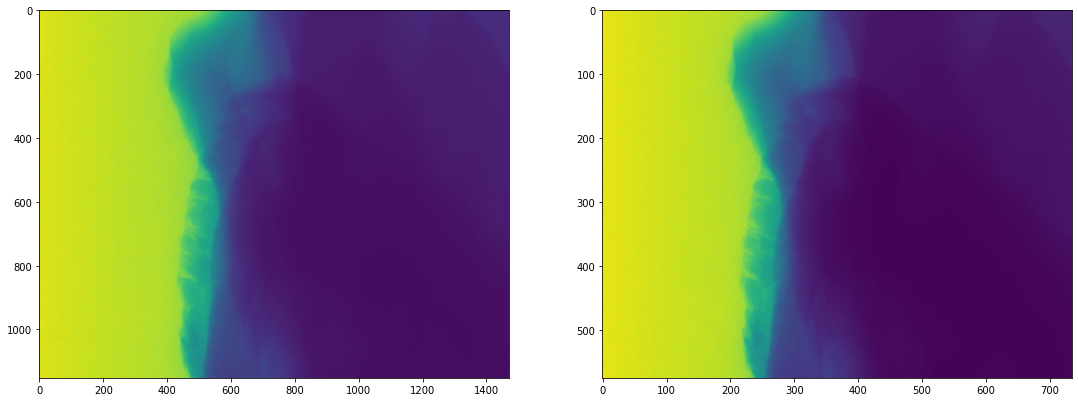

In [20]:
img0 = tiff.imread('H:\\Fanti_Muscioni\\Y3_Xm45\\out\\tomo_0606.tif')
dim1, dim2 = img0.shape
print(img0.shape)
img1 = congrid_py(img0, (dim2//2, dim1//2))

print(img1.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(img0)
ax2.imshow(img1)